In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut, cross_val_score, GridSearchCV

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import (accuracy_score, 
                            confusion_matrix, 
                            classification_report,
                            f1_score,
                            plot_confusion_matrix,
                            precision_recall_curve,
                            precision_score,
                            recall_score)

In [26]:
pwd

'/Users/emilynaftalin/Data_Science/General Assembly/dsi/projects/Mass-Protests/users'

In [27]:
mass = pd.read_csv('../data/mass_mobile.csv')

In [28]:
mass.drop(columns=['Unnamed: 0'], inplace=True)

In [29]:
mass.head(2)

id country  ccode         region  protestnumber  protesterviolence  \
0  201990001  Canada     20  North America              1                0.0   
1  201990002  Canada     20  North America              2                0.0   

           location protesteridentity  \
0          national       unspecified   
1  Montreal, Quebec       unspecified   

                                             sources  \
0  1. great canadian train journeys into history;...   
1  1. autonomy s cry revived in quebec the new yo...   

                                               notes  ... social_restrictions  \
0  canada s railway passenger system was finally ...  ...                   0   
1  protestors were only identified as young peopl...  ...                   0   

   start_date    end_date                 target  \
0  1990-01-15  1990-01-15  [0, 0, 0, 0, 1, 0, 0]   
1  1990-06-25  1990-06-25  [0, 0, 0, 0, 1, 0, 0]   

                                         notes_clean    neg    neu  pos  \
0  canada s railway passenger system was finally ...  0.087  0.913  0.0   
1  protestors were only identified as young peopl...  0.000  1.000  0.0   

   compound  protest_duration  
0   -0.8176                 1  
1    0.0000                 1  

[2 rows x 234 columns]

In [30]:
# sorted(list(mass.columns))

In [31]:
# mass.info(verbose=True)

In [32]:
def evaluate_model(y_true, y_preds):
    
    '''
    DOCSTRING HERE
    '''
    
    f1 = f1_score(y_true, y_preds)
    
    precision = precision_score(y_true, y_preds)
    
    recall = recall_score(y_true, y_preds)

    # add accuracy

    return f1, precision, recall

In [33]:
# def build_confusion_matrix(y_true, y_preds, title):
    
#     tn, fp, fn, tp = confusion_matrix(y_true, y_preds).ravel()
#     disp = plot_confusion_matrix(model, 
#                                  X_test_sc, 
#                                  y_test, 
# #                                  display_labels=
#                                  cmap="Blues")
    
#     disp.ax_.set_title(title)
#     print(title)
#     print(disp.confusion_matrix)
    
#     plt.show
    
#     return

In [34]:
def response_prediction_columns(model, df, features):
    
    ss = StandardScaler()
    
    X = features
    X_sc = ss.fit_transform(X)
    
    predicted_column = model.predict(X_sc)
    probability_column = model.predict_proba(X_sc)[:,1]
    
    return predicted_column, probability_column

In [35]:
def state_response_predictor(df, features, target, model):
    
    X = features 
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=48)

    ss = StandardScaler()

    X_train_sc = ss.fit_transform(X_train)
    X_test_sc = ss.transform(X_test)
    
    model.fit(X_train_sc, y_train)
    
    y_preds_train = model.predict(X_train_sc)
    y_preds_test = model.predict(X_test_sc)
    
    f1_score_train, precision_train, recall_train = evaluate_model(y_train, y_preds_train)
    f1_score_test, precision_test, recall_test = evaluate_model(y_test, y_preds_test)
    
#     print(f'{target}- F1_score for {model} model, train set: {f1_score_train}')
#     print(f'{target}- F1_score for {model} model, test set: {f1_score_test}')
#     print(f'{target}- Precision for {model} model, train set: {precision_train}')
#     print(f'{target}- Precision for {model} model, test set: {precision_test}')
#     print(f'{target}- Recall for {model} model, train set: {recall_train}')
#     print(f'{target}- Recall for {model} model, teset set: {recall_test}')
    
    predicted_column, probability_column = response_prediction_columns(model, df, features)
    
#     print(model)

#     build_confusion_matrix(y_test, y_preds_test)

    return predicted_column, probability_column, f1_score_train, f1_score_test, precision_train, precision_test, recall_train, recall_test  

Creating two new columns that consolidate the three violent state responses -- `beatings, shootings, killings`.
+ `violent_response`: indicates whether or not a violdnt state response was used. (0 for no, 1 for yes)
+ `violent_count`: indicates number (0,1,2,3) of violent ressponses that were recorded. (I anticipate this will be used just to judge collinearity/dependence.)

_NB: Not yet dropping the original three columns._

In [36]:
mass['violent_response'] = 0 
# mass.loc[ (mass['beatings'] == 1 | mass['shootings'] == 1 | mass['killings'] == 1), 'violent_response' ] = 1
mass.loc[mass['beatings'] == 1, 'violent_response'] = 1
mass.loc[mass['shootings'] == 1, 'violent_response'] = 1
mass.loc[mass['killings'] == 1, 'violent_response'] = 1

In [37]:
mass['violent_count'] = mass['beatings'] + mass['shootings'] + mass['killings']

In [38]:
# checking whether the new column looks good 
mass[['beatings', 'shootings','killings', 'violent_response', 'violent_count']]

beatings  shootings  killings  violent_response  violent_count
0             0          0         0                 0              0
1             0          0         0                 0              0
2             0          0         0                 0              0
3             0          0         0                 0              0
4             0          0         0                 0              0
...         ...        ...       ...               ...            ...
15174         0          1         0                 1              1
15175         0          1         1                 1              2
15176         0          0         0                 0              0
15177         0          0         0                 0              0
15178         0          0         0                 0              0

[15179 rows x 5 columns]

In [39]:
mass[ mass['violent_count'] > 1][['beatings', 'shootings','killings', 'violent_response']].count()

beatings            604
shootings           604
killings            604
violent_response    604
dtype: int64

_Saving and pickling `mass` DataFrame that now has `violent_response` and `violent_count` columns. 

_**I'm going to use the `mass_no_country` DataFrame to run this gridsearch since it has been shown to perform better and will save time (I hope!)**_

In [42]:
mass_no_country = pd.read_pickle('../data/mass_no_country.pickle')

In [44]:
# mass_no_country.info()

In [45]:
targets = ['arrests','accomodation','crowddispersal','ignore', 'violent_response']  

grids = []

for target in targets:    
    
    features = mass_no_country.drop(columns=['country', 'ccode', 'region', 'location','protesteridentity', 'sources',
           'notes', 'protester_id_type', 'protest_size_category', 'start_date', 'notes_clean', 'neg', 'neu', 'pos',
           'end_date', 'target', 'arrests', 'accomodation', 'beatings',
           'crowddispersal', 'ignore', 'killings', 'shootings', 'violent_response'])
    
    X = features
    y = mass_no_country[target]
    
    logreg = LogisticRegression()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=48)
    
    ss = StandardScaler()
    
    X_train_sc = ss.fit_transform(X_train)
    X_test_sc = ss.transform(X_test)
    
    params = {
        'penalty' : ['l1','l2'], 
        'C' : [.01, 1, 10],
        'solver' : ['liblinear', 'saga', 'lfgbs'],
        'max_iter' : [100, 1000]
    }
    
    gs = GridSearchCV(logreg, param_grid=params, cv=10, verbose=2)
    
    #print(y)
    grids.append(gs)

In [54]:
# plt.scatter(mass_no_country['protestnumber'], mass_no_country['violent_response'])

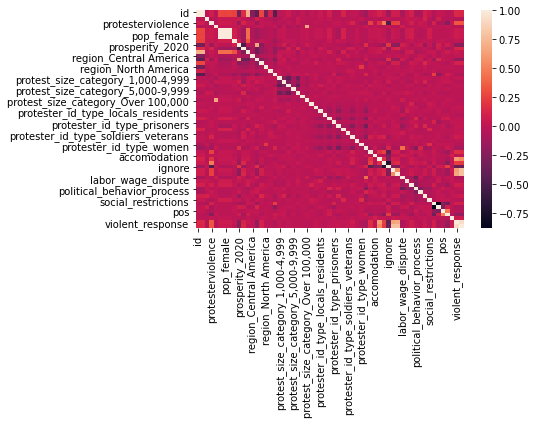

In [58]:
sns.heatmap(mass_no_country.corr());

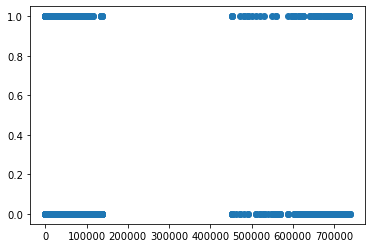

In [59]:
plt.scatter(mass_no_country['pop_male'], mass_no_country['violent_response'])

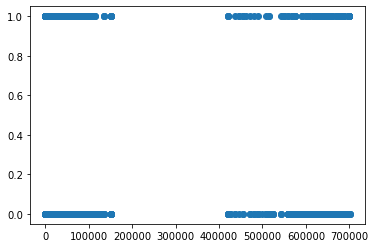

In [60]:
plt.scatter(mass_no_country['pop_female'], mass_no_country['violent_response'])

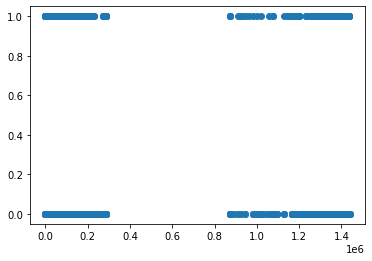

In [61]:
plt.scatter(mass_no_country['pop_total'], mass_no_country['violent_response'])

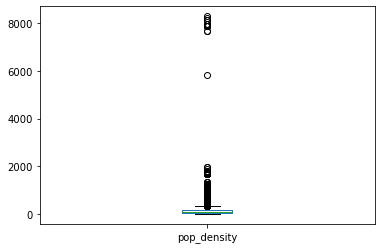

In [64]:
mass_no_country['pop_density'].plot(kind='box');

In [69]:
from scipy import stats

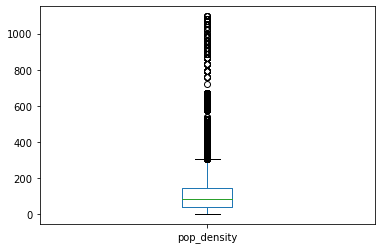

In [73]:
mass_no_country = mass_no_country[(np.abs(stats.zscore(mass_no_country['pop_density'])) < 3)]
mass_no_country['pop_density'].plot(kind='box');

In [71]:
mass_no_country.shape

(15179, 71)

In [72]:
f.shape

(14944, 71)

In [75]:
# plt.scatter(mass_no_country['protesterviolence'], mass_no_country['violent_response'])

In [67]:
# sorted(list(mass_no_country['pop_total']))

In [46]:
# NEW CODE 

results = {
    'target':[]
    'best_cv_scores' : [],
    'best_params' : [],
    'train_f1_scores' : [],
    'test_f1_scores' : [],
    'train_precision_scores' : [], 
    'test_precision_scores' : [],
    'train_recall_scores' : [],
    'test_recall_scores' : []
}

targets = ['arrests','accomodation','crowddispersal','ignore', 'violent_response']   
# grids =[]


for target in targets:    
    
    features = mass_no_country.drop(columns=['id', 'country', 'ccode', 'region', 'location','protesteridentity', 'sources',
           'notes', 'protester_id_type', 'protest_size_category', 'start_date', 'notes_clean', 'neg', 'neu', 'pos', 'compound',
           'end_date', 'target', 'arrests', 'accomodation', 'beatings', 'protest_duration', 'pop_male', 'pop_female', 'pop_total',
           'crowddispersal', 'ignore', 'killings', 'shootings', 'violent_response', 'violent_count'])
    
    X = features
    y = mass_no_country[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=48)
    
    ss = StandardScaler()
    
    X_train_sc = ss.fit_transform(X_train)
    X_test_sc = ss.transform(X_test)
    
    
    params = {
        'penalty' : ['l1','l2'], 
        'C' : [.01, 1, 10],
        'solver' : ['liblinear', 'saga', 'lfgbs'],
        'max_iter' : [100, 1000]
    }
    
    gs = GridSearchCV(logreg, param_grid=params, cv=10, verbose=2)
    
    #print(y)
#     grids.append(gs)
    
#     for grid in grids: 
        
    # fit grids
    gs.fit(X_train_sc, y_train)
    
    # appending name of target to identify results 
    results['target'].append(target)

    # append important grid results
    results['best_params'].append(gs.best_params_)
    results['best_cv_scores'].append(gs.best_score_)

    # make predictions 
    train_preds = gs.predict(X_train_sc)
    test_preds = gs.predict(X_test_sc)

    # various classification metrics
    # f1 scores
    results['train_f1_scores'].append(f1_score(y_train, train_preds))
    results['test_f1_scores'].append(f1_score(y_test, test_preds))

    # precision scores 
    results['train_precision_scores'].append(precision_score(y_train, train_preds))
    results['test_precision_scores'].append(precision_score(y_test, test_preds))

    # recall scores
    results['train_recall_scores'].append(recall_score(y_train, train_preds))
    results['test_recall_scores'].append(recall_score(y_test, test_preds))

Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.3s
[CV] END ......C=0.01, max_iter=100, penalty=l

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.9s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   1.6s
[CV] END ......C=0.01, max_i

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.7s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.5s
[CV] END .....C=0.01, max_it

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.6s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.5s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.6s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.8s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.4s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.6s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.4s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.4s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   2.4s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   2.0s
[CV] END .....C=0.01, max_it

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=  18.4s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=  17.2s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=  17.9s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=  21.5s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=  20.6s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=  18.0s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=  20.7s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=  20.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=  21.4s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=  20.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   2.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   2.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   2.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.5s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ....C=1, max_iter=100, penalty=l2, solver=liblinear; total time=   0.4s
[CV] END ....C=1, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   1.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   1.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   1.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   1.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   1.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   1.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   1.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   1.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   1.2s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ...C=1, max_iter=1000, penalty=l1, solver=liblinear; total time=  21.7s
[CV] END ...C=1, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=  13.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=  13.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=  14.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=  12.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=  13.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=  13.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=  12.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=  13.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=  12.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=  12.7s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END ...C=1, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   9.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   9.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=  10.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=  12.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=  11.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=  10.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   9.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=  10.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=  10.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   9.3s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=  20.5s
[CV] END ...C=10, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   2.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   2.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.3s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l2, solver=liblinear; total time=   0.5s
[CV] END ...C=10, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   1.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   1.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   1.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   1.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   1.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   1.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   1.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   1.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   1.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ..C=10, max_iter=1000, penalty=l1, solver=liblinear; total time=  20.5s
[CV] END ..C=10, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  14.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  11.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  12.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  11.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  11.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  12.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  11.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  11.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  15.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  11.9s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.5s
[CV] END ..C=10, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=  11.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=  12.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=  13.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=  10.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=  10.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=  11.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=  12.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=  15.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=  13.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=  10.8s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.2s
[CV] END ......C=0.01, max_iter=100, penalty=l

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.9s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.7s
[CV] END ......C=0.01, max_i

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.4s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.4s
[CV] END .....C=0.01, max_it

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   1.0s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.8s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   1.7s
[CV] END .....C=0.01, max_it

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=  18.9s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=  20.7s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=  16.5s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=  20.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=  20.1s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=  19.2s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=  17.0s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=  17.3s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=  20.5s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=  17.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.6s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ....C=1, max_iter=100, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END ....C=1, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   1.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   1.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   1.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.9s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ...C=1, max_iter=1000, penalty=l1, solver=liblinear; total time=  19.1s
[CV] END ...C=1, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=  13.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=  10.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=  10.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   9.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   9.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=  10.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=  10.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   9.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=  11.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=  12.3s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=1, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   8.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=  10.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=  11.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   8.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   9.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   9.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   9.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   9.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   9.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=  10.4s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=  21.8s
[CV] END ...C=10, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=  23.3s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=  21.6s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=  24.3s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=  20.6s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=  23.2s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=  21.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.7s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l2, solver=liblinear; total time=   0.4s
[CV] END ...C=10, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   1.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   1.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   1.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   1.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   1.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   1.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.9s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ..C=10, max_iter=1000, penalty=l1, solver=liblinear; total time=  23.6s
[CV] END ..C=10, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  13.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  10.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   8.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  11.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  13.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  12.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  14.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  15.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   9.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   9.5s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.4s
[CV] END ..C=10, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   8.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   8.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   8.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   7.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   6.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   8.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=  12.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   8.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=  11.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   9.2s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV] END .C=0.01, max_iter=100, penalty=l1, so

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   1.0s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   1.0s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.5s
[CV] END ......C=0.01, max_i

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.5s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.5s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_it

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ....C=0.01, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ....C=0.01, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ....C=0.01, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ....C=0.01, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ....C=0.01, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ....C=0.01, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=  15.3s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=  15.4s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=  13.0s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=  19.9s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=  17.1s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=  17.4s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=  16.4s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=  15.0s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=  17.3s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=  17.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.3s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ....C=1, max_iter=100, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ....C=1, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   1.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   1.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   1.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.8s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ...C=1, max_iter=1000, penalty=l1, solver=liblinear; total time=  16.2s
[CV] END ...C=1, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=  11.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=  11.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=  13.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=  11.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   9.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   9.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=  13.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=  18.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=  13.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=  12.4s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=1, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   9.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   8.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=  12.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   9.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   8.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   9.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=  14.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   9.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=  10.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=  10.4s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=  26.0s
[CV] END ...C=10, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END ...C=10, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   1.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   1.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.8s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ..C=10, max_iter=1000, penalty=l1, solver=liblinear; total time=  21.9s
[CV] END ..C=10, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  10.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  10.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  12.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   9.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  12.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  12.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  10.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  13.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  10.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  12.6s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.4s
[CV] END ..C=10, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   9.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=  10.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=  13.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=  10.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   9.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=  12.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=  13.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=  12.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=  14.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=  10.8s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.4s
[CV] END ......C=0.01, max_iter=100, penalty=l

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.9s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.8s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.5s
[CV] END ......C=0.01, max_i

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_it

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.4s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.6s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.7s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.5s
[CV] END .....C=0.01, max_it

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=  19.7s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=  12.9s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=  20.5s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=  15.7s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=  19.5s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=  14.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=  13.2s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=  15.3s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=  17.2s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=  17.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.1s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ....C=1, max_iter=100, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ....C=1, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   1.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   1.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   1.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   1.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   1.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   1.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.9s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ...C=1, max_iter=1000, penalty=l1, solver=liblinear; total time=  15.4s
[CV] END ...C=1, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=  16.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=  11.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=  10.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=  10.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   9.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=  12.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=  14.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=  21.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=  18.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   9.1s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END ...C=1, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   7.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   8.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=  10.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   8.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   9.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   7.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   7.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   7.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   7.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   7.8s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=  16.1s
[CV] END ...C=10, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=  14.5s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=  16.2s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=  16.8s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=  17.1s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=  16.7s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=  14.7s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=  17.1s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=  15.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.1s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l2, solver=liblinear; total time=   0.4s
[CV] END ...C=10, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.7s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ..C=10, max_iter=1000, penalty=l1, solver=liblinear; total time=  18.8s
[CV] END ..C=10, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  12.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  11.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  15.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  11.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  12.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  10.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  10.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  14.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  11.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  12.8s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END ..C=10, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   8.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   9.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   9.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   8.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   8.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   9.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   8.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   8.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   8.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=  10.8s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV] END .C=0.01, max_iter=100, penalty=l1, so

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.5s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.5s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.5s
[CV] END ......C=0.01, max_i

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_it

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.6s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   1.1s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.9s
[CV] END .....C=0.01, max_it

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=  14.8s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=  15.2s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=  16.4s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=  14.8s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=  14.7s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=  23.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=  16.7s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=  15.9s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=  16.7s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=  18.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   2.8s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ....C=1, max_iter=100, penalty=l2, solver=liblinear; total time=   0.5s
[CV] END ....C=1, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   1.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   1.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   1.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   1.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   1.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   1.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   1.1s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ...C=1, max_iter=1000, penalty=l1, solver=liblinear; total time=  14.8s
[CV] END ...C=1, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=  10.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=  12.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   9.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=  11.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=  11.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=  13.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   9.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=  16.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=  11.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   9.8s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=1, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   8.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   7.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   7.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   8.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   8.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=  10.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   8.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=  10.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=  15.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=  14.5s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=  19.0s
[CV] END ...C=10, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l2, solver=liblinear; total time=   0.5s
[CV] END ...C=10, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   1.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.7s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ..C=10, max_iter=1000, penalty=l1, solver=liblinear; total time=  18.1s
[CV] END ..C=10, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   8.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   9.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  13.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   9.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  16.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  10.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  11.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  10.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   9.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   9.5s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.4s
[CV] END ..C=10, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=  13.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   9.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=  15.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   9.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=  11.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=  10.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=  13.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=  13.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=  10.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=  10.6s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV] END .C=0.01, max_iter=100, penalty=l1, so

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   1.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.9s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   1.1s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   1.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   1.2s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   1.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   1.6s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   1.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   1.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   1.7s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.9s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   1.3s
[CV] END .....C=0.01, max_it

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   1.0s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   1.7s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.5s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.5s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.6s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   1.0s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.8s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.6s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   1.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   2.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   2.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.8s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ....C=1, max_iter=100, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ....C=1, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.9s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ...C=1, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.5s
[CV] END ...C=1, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=  12.2s
[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=  12.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=  11.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   9.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=  14.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   6.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   8.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   9.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   6.1s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=  11.7s
[CV] END ...C=10, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.8s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=10, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   1.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   1.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.6s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ..C=10, max_iter=1000, penalty=l1, solver=liblinear; total time=  15.7s
[CV] END ..C=10, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   9.9s
[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   5.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   9.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   9.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  10.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   9.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  10.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  12.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  11.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  10.7s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END ..C=10, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   8.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=  33.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=  29.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=  20.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=  22.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=  13.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=  13.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=  14.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   8.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   8.9s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV] END .C=0.01, max_iter=100, penalty=l1, so

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   1.0s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.9s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.8s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.8s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.8s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.9s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   2.4s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END C=0.01, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.4s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_it

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   3.1s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   2.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   2.2s
[CV] END .....C=0.01, max_it

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   1.3s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   1.7s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   1.4s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   1.2s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.7s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   1.3s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.5s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ....C=1, max_iter=100, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ....C=1, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   1.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   1.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   1.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.8s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ...C=1, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.9s
[CV] END ...C=1, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=  12.6s
[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=  14.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=  14.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=  11.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   9.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   9.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   8.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=  14.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   9.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   8.3s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=  15.0s
[CV] END ...C=10, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l2, solver=liblinear; total time=   0.4s
[CV] END ...C=10, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   1.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.8s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ..C=10, max_iter=1000, penalty=l1, solver=liblinear; total time=  13.4s
[CV] END ..C=10, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   9.7s
[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   4.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   9.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  10.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  10.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  10.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   9.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   9.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=  10.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   9.7s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ..C=10, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   8.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   8.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   8.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   7.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   7.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   7.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   8.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   8.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   9.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   8.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV] END .C=0.01, max_iter=100, penalty=l1, so

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   1.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.9s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.7s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.9s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.7s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   1.0s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.9s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   1.1s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END C=0.01, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.4s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_it

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.8s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.8s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.8s
[CV] END .....C=0.01, max_it

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   1.3s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   1.0s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.5s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.7s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   2.6s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   1.0s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.5s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   1.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.9s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ....C=1, max_iter=100, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ....C=1, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   2.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=  11.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   7.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   3.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   3.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   6.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   3.5s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ...C=1, max_iter=1000, penalty=l1, solver=liblinear; total time=   1.7s
[CV] END ...C=1, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.4s
[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   3.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.6s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   8.4s
[CV] END ...C=10, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   8.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   5.6s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   7.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=10, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ..C=10, max_iter=1000, penalty=l1, solver=liblinear; total time=  10.2s
[CV] END ..C=10, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   7.5s
[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   3.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   7.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   7.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   7.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.5s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ..C=10, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.3s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV] END .C=0.01, max_iter=100, penalty=l1, so

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.5s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.4s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.5s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.5s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.5s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.5s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.5s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END C=0.01, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_it

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.5s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.5s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.5s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.5s
[CV] END .....C=0.01, max_it

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.6s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.6s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.5s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.5s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.9s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.7s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ....C=1, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ....C=1, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ...C=1, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END ...C=1, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.3s
[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   3.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.8s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=  10.3s
[CV] END ...C=10, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   9.7s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   4.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=10, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ..C=10, max_iter=1000, penalty=l1, solver=liblinear; total time=   9.3s
[CV] END ..C=10, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.3s
[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   2.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   7.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   7.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   7.6s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.5s
[CV] END ..C=10, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   6.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   7.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.3s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV] END .C=0.01, max_iter=100, penalty=l1, so

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.5s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.4s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.6s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.5s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.5s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.5s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.5s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END C=0.01, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_it

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.8s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.6s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.5s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.5s
[CV] END .....C=0.01, max_it

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.7s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.5s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.5s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.7s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ....C=1, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ....C=1, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ...C=1, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END ...C=1, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.2s
[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   3.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.4s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   9.4s
[CV] END ...C=10, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   6.7s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   7.7s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   8.8s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=  10.4s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   8.7s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   8.7s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=  11.9s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   5.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=10, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.6s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ..C=10, max_iter=1000, penalty=l1, solver=liblinear; total time=  12.7s
[CV] END ..C=10, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.3s
[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   2.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.3s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.4s
[CV] END ..C=10, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.2s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV] END .C=0.01, max_iter=100, penalty=l1, so

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.3s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.3s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.2s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.2s
[CV] END ......C=0.01, max_i

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_it

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_it

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.7s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   1.0s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.6s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.6s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.5s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.9s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.8s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   1.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ....C=1, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ....C=1, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.6s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ...C=1, max_iter=1000, penalty=l1, solver=liblinear; total time=   1.2s
[CV] END ...C=1, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   1.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.5s
[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   0.8s
[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   1.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.5s
[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   2.0s
[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   1.2s
[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   1.4s
[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   1.2s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_ite

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   5.9s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   4.6s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   1.2s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   2.4s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   2.6s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   3.9s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   1.4s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   1.3s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   1.4s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=10, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ..C=10, max_iter=1000, penalty=l1, solver=liblinear; total time=   2.4s
[CV] END ..C=10, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.3s
[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   0.8s
[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   1.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.4s
[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   1.2s
[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   1.1s
[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   1.1s
[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   1.1s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_ite

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   4.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.2s
[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   0.6s
[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.4s
[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   1.0s
[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   1.0s
[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   1.0s
[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   0.9s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_ite

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.3s
[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.2s
[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.2s
[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.2s
[CV] END ......C=0.01, max_i

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.3s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.3s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.2s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.2s
[CV] END ......C=0.01, max_i

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_it

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_it

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.6s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.5s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.9s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   1.4s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   1.0s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.5s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.7s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.7s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ....C=1, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ....C=1, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ...C=1, max_iter=1000, penalty=l1, solver=liblinear; total time=   1.2s
[CV] END ...C=1, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   1.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.2s
[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   0.8s
[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   1.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   6.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.7s
[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   0.9s
[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   0.9s
[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   0.9s
[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   0.8s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_ite

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   1.3s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   3.7s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   1.2s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   1.3s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   2.7s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   4.0s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   1.3s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   2.6s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   2.4s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   1.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=10, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.6s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ..C=10, max_iter=1000, penalty=l1, solver=liblinear; total time=   1.6s
[CV] END ..C=10, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.3s
[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   0.8s
[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   1.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.2s
[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   1.2s
[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   1.1s
[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   1.2s
[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   1.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_ite

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   4.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.2s
[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   0.6s
[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   0.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s
[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   1.0s
[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   0.9s
[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   0.9s
[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   0.9s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_ite

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.3s
[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.3s
[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.2s
[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.3s
[CV] END ......C=0.01, max_i

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.3s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.3s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.1s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.2s
[CV] END ......C=0.01, max_i

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_it

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_it

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.9s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   1.0s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.7s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   1.1s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.5s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   1.5s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   1.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.7s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ....C=1, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ....C=1, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ...C=1, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.5s
[CV] END ...C=1, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   1.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.9s
[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   0.9s
[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   0.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.2s
[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   1.1s
[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   1.0s
[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   0.9s
[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   0.9s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_ite

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   2.6s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   3.8s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   0.9s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   1.3s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   2.8s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   4.0s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   1.5s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   2.6s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   0.9s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   1.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=10, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ..C=10, max_iter=1000, penalty=l1, solver=liblinear; total time=   2.5s
[CV] END ..C=10, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.4s
[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   0.8s
[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   1.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.3s
[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   1.2s
[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   1.2s
[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   1.1s
[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   1.1s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_ite

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   4.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.4s
[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   0.6s
[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.3s
[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   0.9s
[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   1.0s
[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   0.9s
[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   0.9s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_ite

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.3s
[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.2s
[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.1s
[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.2s
[CV] END ......C=0.01, max_i

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.3s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.3s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.1s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.2s
[CV] END ......C=0.01, max_i

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_it

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_it

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.7s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   1.0s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   1.0s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.7s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   1.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.7s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ....C=1, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ....C=1, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.6s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ...C=1, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.9s
[CV] END ...C=1, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   1.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.2s
[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   0.6s
[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.2s
[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   1.0s
[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   0.9s
[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   0.9s
[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   0.8s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_ite

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   1.7s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   4.4s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   1.0s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   2.7s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   4.4s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   4.2s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   0.8s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   3.3s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   1.0s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=10, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ..C=10, max_iter=1000, penalty=l1, solver=liblinear; total time=   1.4s
[CV] END ..C=10, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.8s
[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   0.8s
[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   1.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.4s
[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   1.1s
[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   1.1s
[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   1.1s
[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   1.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_ite

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   4.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.4s
[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   0.6s
[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s
[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   0.9s
[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   0.9s
[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   0.9s
[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   0.8s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_ite

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.2s
[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.2s
[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.2s
[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.2s
[CV] END ......C=0.01, max_i

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.3s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.3s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.2s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.2s
[CV] END ......C=0.01, max_i

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_it

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.4s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.5s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_it

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   1.1s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.7s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.5s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.5s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.8s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.7s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.5s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ....C=1, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ....C=1, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ...C=1, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.6s
[CV] END ...C=1, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   1.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s
[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   0.6s
[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s
[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   0.9s
[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   0.9s
[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   0.8s
[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   0.8s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_ite

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   1.4s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   2.8s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   0.9s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   0.9s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   3.4s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   3.9s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   1.0s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   1.4s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   2.0s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   1.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=10, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ..C=10, max_iter=1000, penalty=l1, solver=liblinear; total time=   1.3s
[CV] END ..C=10, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.8s
[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   0.7s
[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   1.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.2s
[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   1.1s
[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   1.1s
[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   1.1s
[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   1.1s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_ite

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   4.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.5s
[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   0.6s
[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.3s
[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   0.9s
[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   0.9s
[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   0.9s
[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   0.8s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_ite

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.3s
[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.3s
[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.3s
[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.4s
[CV] END ......C=0.01, max_i

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.3s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.3s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.3s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.3s
[CV] END ......C=0.01, max_i

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.4s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_it

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.4s
[CV] END .....C=0.01, max_it

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.7s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   1.3s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   1.5s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   2.3s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.5s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   1.2s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   1.4s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.5s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   1.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ....C=1, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ....C=1, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ...C=1, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.5s
[CV] END ...C=1, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   6.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   6.0s
[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   5.5s
[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   1.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   6.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   6.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   6.1s
[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   1.4s
[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   4.6s
[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   5.2s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_ite

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   3.9s
[CV] END ...C=10, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=10, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ..C=10, max_iter=1000, penalty=l1, solver=liblinear; total time=   3.9s
[CV] END ..C=10, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.3s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ..C=10, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV] END .C=0.01, max_iter=100, penalty=l1, so

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.3s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.3s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.3s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.3s
[CV] END ......C=0.01, max_i

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.4s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_it

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_it

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.8s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   1.4s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.7s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.5s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   2.0s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.9s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   2.3s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   1.4s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   2.8s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   1.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ....C=1, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ....C=1, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ...C=1, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.7s
[CV] END ...C=1, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   6.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   6.1s
[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   5.5s
[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   1.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   6.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   6.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   6.2s
[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   1.4s
[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   4.7s
[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   5.5s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_ite

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   6.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   6.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   7.1s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   5.3s
[CV] END ...C=10, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=10, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ..C=10, max_iter=1000, penalty=l1, solver=liblinear; total time=   5.2s
[CV] END ..C=10, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.3s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ..C=10, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   6.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV] END .C=0.01, max_iter=100, penalty=l1, so

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.3s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.3s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.3s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.3s
[CV] END ......C=0.01, max_i

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.4s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_it

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_it

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.5s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.9s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   3.0s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.9s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   2.3s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   1.7s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.6s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ....C=1, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ....C=1, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ...C=1, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END ...C=1, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   6.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   6.1s
[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   5.5s
[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   1.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   6.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   6.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   6.4s
[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   1.5s
[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   4.9s
[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   5.2s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_ite

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   5.9s
[CV] END ...C=10, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   1.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=10, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ..C=10, max_iter=1000, penalty=l1, solver=liblinear; total time=   4.1s
[CV] END ..C=10, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.1s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ..C=10, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV] END .C=0.01, max_iter=100, penalty=l1, so

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.3s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.3s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.3s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.3s
[CV] END ......C=0.01, max_i

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.4s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_it

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_it

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.7s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   2.4s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.5s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   1.5s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   2.1s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.7s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   1.2s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.5s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.5s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ....C=1, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ....C=1, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ...C=1, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.6s
[CV] END ...C=1, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   6.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   6.2s
[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   5.6s
[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   1.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   6.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   6.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   6.2s
[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   1.5s
[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   4.5s
[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   5.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_ite

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   4.1s
[CV] END ...C=10, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=10, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ..C=10, max_iter=1000, penalty=l1, solver=liblinear; total time=   5.2s
[CV] END ..C=10, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.4s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ..C=10, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV] END .C=0.01, max_iter=100, penalty=l1, so

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.4s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.3s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.3s
[CV] END ......C=0.01, max_iter=100, penalty=l2, solver=saga; total time=   0.3s
[CV] END ......C=0.01, max_i

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.4s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_it

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_it

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.7s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   2.4s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.7s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   3.0s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.6s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   3.0s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.5s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ....C=1, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ....C=1, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ...C=1, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.7s
[CV] END ...C=1, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   6.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   6.5s
[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   5.6s
[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   1.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   6.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   6.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   6.1s
[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   1.4s
[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   4.5s
[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   5.5s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_ite

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   4.4s
[CV] END ...C=10, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=10, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ..C=10, max_iter=1000, penalty=l1, solver=liblinear; total time=   3.6s
[CV] END ..C=10, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.2s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ..C=10, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV] END .C=0.01, max_iter=100, penalty=l1, so

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.6s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.8s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.8s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.7s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.8s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.9s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.8s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.8s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.8s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.8s
[CV] END .....C=0.01, max_it

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.4s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_it

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ....C=1, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ....C=1, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ...C=1, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...C=1, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   6.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   5.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   6.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   6.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   6.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   5.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   5.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   5.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   5.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   5.8s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=10, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ..C=10, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ..C=10, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   7.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   8.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   5.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   5.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   5.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   5.8s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=10, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV] END .C=0.01, max_iter=100, penalty=l1, so

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.6s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.9s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.9s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.7s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.8s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.9s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.8s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.9s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.8s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.9s
[CV] END .....C=0.01, max_it

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_it

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ....C=1, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ....C=1, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.6s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ...C=1, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...C=1, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   6.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   5.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   6.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   6.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   5.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   5.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   5.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   5.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   5.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   5.8s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=10, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ..C=10, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..C=10, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   5.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   5.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   5.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   5.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   5.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   8.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   5.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   5.9s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=10, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV] END .C=0.01, max_iter=100, penalty=l1, so

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.6s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.8s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.8s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.7s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.8s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.9s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.8s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.9s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.8s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.8s
[CV] END .....C=0.01, max_it

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_it

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ....C=1, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ....C=1, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ...C=1, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...C=1, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   6.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   6.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   5.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   5.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   5.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   5.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   5.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   5.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   5.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   5.8s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=10, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ..C=10, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..C=10, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   5.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   5.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   5.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   5.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   5.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   5.8s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=10, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   7.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV] END .C=0.01, max_iter=100, penalty=l1, so

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.6s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.9s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.9s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.7s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.9s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.9s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.8s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.8s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.8s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.8s
[CV] END .....C=0.01, max_it

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.4s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.4s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.4s
[CV] END .....C=0.01, max_it

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ....C=1, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ....C=1, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ...C=1, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...C=1, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   6.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   5.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   5.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   5.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   5.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   5.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   5.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   6.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   5.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   5.8s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.7s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=10, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ..C=10, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..C=10, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   5.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   5.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   5.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   5.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=10, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.2s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.4s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV] END .C=0.01, max_iter=100, penalty=l1, so

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ......C=0.01, max_iter=100, penalty=l1, solver=saga; total time=   0.6s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.8s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.8s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.7s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.8s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.9s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.8s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.8s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.8s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.8s
[CV] END .....C=0.01, max_it

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.4s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.5s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.4s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_it

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....C=1, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .........C=1, max_iter=100, penalty=l1, solver=saga; total time=   0.6s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ....C=1, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ....C=1, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .........C=1, max_iter=100, penalty=l2, solver=saga; total time=   0.5s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ........C=1, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ...C=1, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...C=1, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   5.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   5.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   5.7s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   5.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   5.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   5.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   5.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   5.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   5.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   5.9s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=1, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got lfgbs.

  warnings.warn("

[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=10, max_iter=100, penalty=l1, solver=saga; total time=   0.6s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ...C=10, max_iter=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=10, max_iter=1

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=   0.5s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END .......C=10, max_iter=100, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ..C=10, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..C=10, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   6.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   5.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   5.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   5.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   5.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   5.9s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   5.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   5.8s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l1, solver=lfgbs; total time=   0.0s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=10, max_iter=10

/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.8s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.1s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.3s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.3s
[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   5.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s
[CV] END ......C=10, max_iter=1000, penalty=l2, solver=lfgbs; total time=   0.0s


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line

In [51]:
pd.options.display.max_colwidth = 150

In [52]:
results_df = pd.DataFrame(results)
results_df

best_cv_scores  \
0         0.858108   
1         0.858108   
2         0.858108   
3         0.858108   
4         0.858108   
5         0.899119   
6         0.899119   
7         0.899119   
8         0.899119   
9         0.899119   
10        0.787367   
11        0.787367   
12        0.787367   
13        0.787367   
14        0.787367   
15        0.771802   
16        0.771802   
17        0.771802   
18        0.771802   
19        0.771802   
20        1.000000   
21        1.000000   
22        1.000000   
23        1.000000   
24        1.000000   

                                                              best_params  \
0    {'C': 0.01, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}   
1    {'C': 0.01, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}   
2    {'C': 0.01, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}   
3    {'C': 0.01, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}   
4    {'C': 0.01, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}   
5      {'C': 10, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}   
6      {'C': 10, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}   
7      {'C': 10, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}   
8      {'C': 10, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}   
9      {'C': 10, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}   
10   {'C': 0.01, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}   
11   {'C': 0.01, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}   
12   {'C': 0.01, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}   
13  {'C': 0.01, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}   
14  {'C': 0.01, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}   
15   {'C': 0.01, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}   
16   {'C': 0.01, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}   
17   {'C': 0.01, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}   
18   {'C': 0.01, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}   
19   {'C': 0.01, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}   
20   {'C': 0.01, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}   
21   {'C': 0.01, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}   
22   {'C': 0.01, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}   
23   {'C': 0.01, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}   
24   {'C': 0.01, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}   

    train_f1_scores  test_f1_scores  train_precision_scores  \
0          0.000000        0.000000                0.000000   
1          0.000000        0.000000                0.000000   
2          0.000000        0.000000                0.000000   
3          0.000000        0.000000                0.000000   
4          0.000000        0.000000                0.000000   
5          0.031646        0.006667                0.526316   
6          0.031646        0.006667                0.526316   
7          0.031646        0.006667                0.526316   
8          0.031646        0.006667                0.526316   
9          0.031646        0.006667                0.526316   
10         0.629885        0.619247                0.697423   
11         0.629688        0.619247                0.697327   
12         0.629885        0.619247                0.697423   
13         0.629688        0.619247                0.697327   
14         0.629885        0.619247                0.697423   
15         0.814859        0.815106                0.727859   
16         0.814859        0.815106                0.727859   
17         0.814859        0.815106                0.727859   
18         0.814859        0.815106                0.727859   
19         0.814859        0.815106                0.727859   
20         1.000000        1.000000                1.000000   
21         1.000000        1.000000       

In [47]:
results

{'best_cv_scores': [0.8581076738462791,
  0.8581076738462791,
  0.8581076738462791,
  0.8581076738462791,
  0.8581076738462791,
  0.899118717839201,
  0.899118717839201,
  0.899118717839201,
  0.899118717839201,
  0.899118717839201,
  0.7873672042901403,
  0.7873672042901403,
  0.7873672042901403,
  0.7873672042901403,
  0.7873672042901403,
  0.7718018182927573,
  0.7718018182927573,
  0.7718018182927573,
  0.7718018182927573,
  0.7718018182927573,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'best_params': [{'C': 0.01,
   'max_iter': 100,
   'penalty': 'l1',
   'solver': 'liblinear'},
  {'C': 0.01, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'},
  {'C': 0.01, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'},
  {'C': 0.01, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'},
  {'C': 0.01, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'},
  {'C': 10, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'},
  {'C': 10, 'max_iter': 100, 'penalty': 'l1', 'solver': '

In [2]:
# results = {
#     'best_cv_scores' : [],
#     'best_params' : [],
#     'train_f1_scores' : [],
#     'test_f1_scores' : [],
#     'train_precision_scores' : [], 
#     'test_precision_scores' : [],
#     'train_recall_scores' : [],
#     'test_recall_scores' : []
# }

# for grid in grids: 
    
#     # fit grids
#     grid.fit(X_train_sc, y_train)
    
#     # append important grid results
#     results['best_params'].append(grid.best_params_)
#     results['best_cv_scores'].append(grid.best_score_)
    
#     # make predictions 
#     train_preds = grid.predict(X_train_sc)
#     test_preds = grid.predict(X_test_sc)
    
#     # various classification metrics
#     # f1 scores
#     results['train_f1_scores'].append(f1_score(y_train, train_preds))
#     results['test_f1_scores'].append(f1_score(y_test, test_preds))
    
#     # precision scores 
#     results['train_precision_scores'].append(precision_score(y_train, train_preds))
#     results['test_precision_scores'].append(precision_score(y_test, test_preds))
    
#     # recall scores
#     results['train_recall_scores'].append(recall_score(y_train, train_preds))
#     results['test_recall_scores'].append(recall_score(y_test, test_preds))
    
# results_df = pd.DataFrame(results)
# results_df

In [191]:
# mass.to_csv('../data/03_mass_violent_response.csv', index=False)

In [193]:
# mass.to_pickle('../data/03_mass_violent_response.pickle')

In [195]:
features = mass.drop(columns=['country', 'ccode', 'region', 'location','protesteridentity', 'sources',
           'notes', 'protester_id_type', 'protest_size_category', 'start_date', 'notes_clean', 'neg', 'neu', 'pos',
           'end_date', 'target', 'arrests', 'accomodation', 'beatings', 'crowddispersal', 'ignore', 'killings', 'shootings', 
            'violent_response', 'violent_count'])

LogisticRegression_1 = LogisticRegression(solver='lbfgs', max_iter=1000)

In [196]:
# (mass.drop(columns=['country', 'ccode', 'region', 'location','protesteridentity', 'sources',
#            'notes', 'protester_id_type', 'protest_size_category', 'start_date', 'notes_clean', 'neg', 'neu', 'pos',
#            'end_date', 'target', 'arrests', 'accomodation', 'beatings',
#            'crowddispersal', 'ignore', 'killings', 'shootings'])).columns

**Adding `predicted` and `probability` columns for each each response to the `mass` DF using `state_response_predictor` function.** 

Responses: `'arrests','accomodation','beatings','crowddispersal','ignore','killings','shootings'`

In [197]:
mass['arrests_predicted'], mass['arrests_probability'], \
f1_score_train, f1_score_test, precision_train, precision_test, recall_train, recall_test = \
state_response_predictor(mass, features, 'arrests', LogisticRegression_1)

In [198]:
mass['accomodation_predicted'], mass['accomodation_probability'], \
f1_score_train, f1_score_test, precision_train, precision_test, recall_train, recall_test = \
state_response_predictor(mass, features, 'accomodation', LogisticRegression_1)

In [199]:
# looking at where accomodation is '1' and it was also correctly predicted 

mass[ (mass['accomodation'] == mass['accomodation_predicted']) & mass['accomodation']==1 ][['accomodation', 'accomodation_predicted', 'accomodation_probability']]

accomodation  accomodation_predicted  accomodation_probability
451               1                       1                  0.921425
1438              1                       1                  0.609061
1469              1                       1                  0.550764
1679              1                       1                  0.596815
2061              1                       1                  0.540708
...             ...                     ...                       ...
14736             1                       1                  0.609921
14737             1                       1                  0.840545
15133             1                       1                  0.524657
15149             1                       1                  0.531713
15152             1                       1                  0.611932

[83 rows x 3 columns]

In [200]:
mass['beatings_predicted'], mass['beatings_probability'], f1_score_train, \
f1_score_test, precision_train, precision_test, recall_train, recall_test = \
state_response_predictor(mass, features, 'beatings', LogisticRegression_1)

In [201]:
mass['crowddispersal_predicted'], mass['crowddispersal_probability'], \
f1_score_train, f1_score_test, precision_train, precision_test, recall_train, recall_test = \
state_response_predictor(mass, features, 'crowddispersal', LogisticRegression_1)

In [202]:
mass['ignore_predicted'], mass['ignore_probability'], \
f1_score_train, f1_score_test, precision_train, precision_test, recall_train, recall_test = \
state_response_predictor(mass, features, 'ignore', LogisticRegression_1)

In [203]:
mass['killings_predicted'], mass['killings_probability'], \
f1_score_train, f1_score_test, precision_train, precision_test, recall_train, recall_test = \
state_response_predictor(mass, features, 'killings', LogisticRegression_1)

In [204]:
mass['shootings_predicted'], mass['shootings_probability'], \
f1_score_train, f1_score_test, precision_train, precision_test, recall_train, recall_test = \
state_response_predictor(mass, features, 'shootings', LogisticRegression_1)

In [205]:
predictions_df = mass[['id','arrests', 'arrests_predicted', 'arrests_probability', 'accomodation', 'accomodation_predicted', 'accomodation_probability', 
      'beatings', 'beatings_predicted', 'beatings_probability', 'crowddispersal', 'crowddispersal_predicted', 'crowddispersal_probability', 
      'ignore', 'ignore_predicted', 'ignore_probability', 'killings', 'killings_predicted', 'killings_probability',
      'killings', 'killings_predicted', 'killings_probability']].copy()

In [206]:
predictions_df.head()

id  arrests  arrests_predicted  arrests_probability  accomodation  \
0  201990001        0                  0             0.148069             0   
1  201990002        0                  0             0.132347             0   
2  201990003        0                  0             0.082134             0   
3  201990004        0                  1             0.585644             1   
4  201990005        1                  0             0.370170             1   

   accomodation_predicted  accomodation_probability  beatings  \
0                       0                  0.125990         0   
1                       0                  0.083107         0   
2                       0                  0.041444         0   
3                       0                  0.295309         0   
4                       0                  0.090058         0   

   beatings_predicted  beatings_probability  ...  crowddispersal_probability  \
0                   0              0.000192  ...                    0.084188   
1                   0              0.000267  ...                    0.064624   
2                   0              0.000125  ...                    0.042882   
3                   0              0.000685  ...                    0.526179   
4                   0              0.000518  ...                    0.376911   

   ignore  ignore_predicted  ignore_probability  killings  killings_predicted  \
0       1                 1            0.706858         0                   0   
1       1                 1            0.749024         0                   0   
2       1                 1            0.807295         0                   0   
3       0                 0            0.066220         0                   0   
4       0                 0            0.166469         0                   0   

   killings_probability  killings  killings_predicted  killings_probability  
0              0.004661         0                   0              0.004661  
1              0.002015         0                   0              0.002015  
2              0.000728         0                   0              0.000728  
3              0.123478         0                   0              0.123478  
4              0.020468         0                   0              0.020468  

[5 rows x 22 columns]

In [207]:
# predictions_df.to_csv('../data/04_predictions_only.csv', index=False)

Adding `predicted` and `probability` columns for a violent response of any type (beatings/shootings/killigs). 

In [208]:
mass['violence_predicted'], mass['violence_probability'], \
f1_score_train, f1_score_test, precision_train, precision_test, recall_train, recall_test = \
state_response_predictor(mass, features, 'violent_response', LogisticRegression_1)

In [215]:
model_performance_dict = {
    'target':[],
    'majority_class':[],
    'majority_percent':[],
#     'model':[],
    'f1_score_train':[],
    'f1_score_test':[],
    'precision_train':[],
    'precision_test':[],
    'recall_train':[],
    'recall_test':[] 
}

 
targets = ['arrests','accomodation','beatings','crowddispersal','ignore','killings','shootings', 'violent_response']    
    
for target in targets:
    
    predicted_column, probability_column, f1_score_train, f1_score_test, precision_train, precision_test, recall_train, recall_test = state_response_predictor(
                                                                                                                                mass, 
                                                                                                                                features, 
                                                                                                                                target, 
                                                                                                                                LogisticRegression_1)
    
    model_performance_dict['target'].append(target)
    model_performance_dict['majority_class'].append(mass[target].value_counts(normalize=True).idxmax())
    model_performance_dict['majority_percent'].append(max(mass[target].value_counts(normalize=True)))
#     model_performance_dict['model'].append(model)
    model_performance_dict['f1_score_train'].append(f1_score_train)
    model_performance_dict['f1_score_test'].append(f1_score_test)
    model_performance_dict['precision_train'].append(precision_train)
    model_performance_dict['precision_test'].append(precision_test)
    model_performance_dict['recall_train'].append(recall_train)
    model_performance_dict['recall_test'].append(recall_test)
    
print(model_performance_dict)
    
model_performance_df = pd.DataFrame(model_performance_dict)
model_performance_df.round(4)

{'target': ['arrests', 'accomodation', 'beatings', 'crowddispersal', 'ignore', 'killings', 'shootings', 'violent_response'], 'majority_class': [0, 0, 0, 0, 1, 0, 0, 0], 'majority_percent': [0.8588181039594176, 0.8997957704723631, 0.9472956057711311, 0.6865406153238026, 0.5434481849924238, 0.9457144739442651, 0.9386652612161539, 0.8753541076487252], 'f1_score_train': [0.24430264357338197, 0.09939759036144577, 0.17173051519154559, 0.6446232626188734, 0.7954094644375178, 0.24191616766467064, 0.24093816631130063, 0.39802336028751123], 'f1_score_test': [0.2722117202268431, 0.06984126984126984, 0.15568862275449102, 0.624173180998196, 0.7837535014005603, 0.1958762886597938, 0.2, 0.35976789168278533], 'precision_train': [0.5690021231422505, 0.6470588235294118, 0.65, 0.7299536116633533, 0.745848279527036, 0.6121212121212121, 0.5947368421052631, 0.6429608127721336], 'precision_test': [0.6605504587155964, 0.55, 0.5416666666666666, 0.7188365650969529, 0.7324607329842932, 0.475, 0.48936170212765956

target  majority_class  majority_percent  f1_score_train  \
0           arrests               0            0.8588          0.2443   
1      accomodation               0            0.8998          0.0994   
2          beatings               0            0.9473          0.1717   
3    crowddispersal               0            0.6865          0.6446   
4            ignore               1            0.5434          0.7954   
5          killings               0            0.9457          0.2419   
6         shootings               0            0.9387          0.2409   
7  violent_response               0            0.8754          0.3980   

   f1_score_test  precision_train  precision_test  recall_train  recall_test  
0         0.2722           0.5690          0.6606        0.1555       0.1714  
1         0.0698           0.6471          0.5500        0.0538       0.0373  
2         0.1557           0.6500          0.5417        0.0989       0.0909  
3         0.6242           0.7300          0.7188        0.5772       0.5515  
4         0.7838           0.7458          0.7325        0.8520       0.8428  
5         0.1959           0.6121          0.4750        0.1507       0.1234  
6         0.2000           0.5947          0.4894        0.1511       0.1257  
7         0.3598           0.6430          0.5741        0.2882       0.2620

target  majority_class  majority_percent  f1_score_train  \
0           arrests               0            0.8588          0.2443   
1      accomodation               0            0.8998          0.0994   
2          beatings               0            0.9473          0.1717   
3    crowddispersal               0            0.6865          0.6446   
4            ignore               1            0.5434          0.7954   
5          killings               0            0.9457          0.2419   
6         shootings               0            0.9387          0.2409   
7  violent_response               0            0.8754          0.3980   

   f1_score_test  precision_train  precision_test  recall_train  recall_test  
0         0.2722           0.5690          0.6606        0.1555       0.1714  
1         0.0698           0.6471          0.5500        0.0538       0.0373  
2         0.1557           0.6500          0.5417        0.0989       0.0909  
3         0.6242           0.7300          0.7188        0.5772       0.5515  
4         0.7838           0.7458          0.7325        0.8520       0.8428  
5         0.1959           0.6121          0.4750        0.1507       0.1234  
6         0.2000           0.5947          0.4894        0.1511       0.1257  
7         0.3598           0.6430          0.5741        0.2882       0.2620

In [211]:
mass['arrests'].value_counts(normalize=True)

0    0.858818
1    0.141182
Name: arrests, dtype: float64

In [212]:
mass['arrests'].value_counts(normalize=True).idxmax()

0

In [213]:
max(mass['arrests'].value_counts(normalize=True))

0.8588181039594176

In [214]:
# mass.info(verbose=True)

_Saving `mass` DataFrame again now that it has the viole